
# 📦 E‑commerce Return Analysis & Feature Set Creation (v2)

This notebook:

1. Loads **distribution_center**, **order_items**, **products**, and **users** CSVs.  
2. Engineers an **extended set of features** recommended for high‑quality return‑propensity modelling.  
3. Provides **clear visualisations** (donut charts, bar plots, histograms) to show how return behaviour varies by key dimensions.  
4. Saves a cleaned modelling dataset to **`returns_features_v2.csv`**.

> **Target:** `RETURN_FLAG` → `1 = returned`, `0 = kept`


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.dpi'] = 110  # sharper charts

# Edit these paths if your CSVs live elsewhere
path_dc  = Path('thelook_ecommerce.distribution_centers.csv')
path_ord = Path('thelook_ecommerce.order_items.csv')
path_prod = Path('thelook_ecommerce.products.csv')
path_users = Path('thelook_ecommerce.users.csv')

# ---------- Load ----------
dc   = pd.read_csv(path_dc)
orders  = pd.read_csv(path_ord,  parse_dates=['created_at','shipped_at','delivered_at','returned_at'])
products= pd.read_csv(path_prod)
users   = pd.read_csv(path_users, parse_dates=['created_at'])

print('Shapes:')
for name, df in [('DistributionCenters', dc),
                 ('OrderItems', orders),
                 ('Products', products),
                 ('Users', users)]:
    print(f'  {name:<18} → {df.shape}')


Shapes:
  DistributionCenters → (10, 4)
  OrderItems         → (180952, 11)
  Products           → (29120, 9)
  Users              → (100000, 15)


In [5]:
# ---------- Target ----------
orders['RETURN_FLAG'] = orders['returned_at'].notna().astype(int)

# ---------- Basket size ----------
orders['basket_size'] = orders.groupby('order_id')['id'].transform('count')

# ---------- Merge master table ----------
df = (orders
      .merge(products[['id','category','department','brand','retail_price','cost','distribution_center_id']],
             left_on='product_id', right_on='id', how='left', suffixes=('', '_prod'))
      .merge(users[['id','gender','age','country','created_at']],
             left_on='user_id', right_on='id', how='left', suffixes=('', '_user'))
      .merge(dc.rename(columns={'id':'distribution_center_id'}), on='distribution_center_id', how='left'))

# ----- Rename to make timestamps explicit -----
df = df.rename(columns={'created_at'     : 'order_created_at',   # from orders
                        'created_at_user': 'user_created_at'})   # from users

# ---------- Ensure correct dtypes ----------
time_cols = ['order_created_at', 'user_created_at', 'shipped_at']
for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)

num_cols = ['sale_price', 'retail_price', 'cost']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# ---------- Derived Features ----------
# Discount %
df['discount_pct'] = (df['retail_price'] - df['sale_price']) / df['retail_price']
df['discount_pct'] = df['discount_pct'].clip(lower=0, upper=1)

# User tenure (days between user sign-up & order)
df['tenure_days'] = (df['order_created_at'] - df['user_created_at']).dt.days

# Shipping latency (days between order & ship)
df['ship_latency_days'] = (df['shipped_at'] - df['order_created_at']).dt.days

# Time features
df['created_hour']      = df['order_created_at'].dt.hour
df['created_dayofweek'] = df['order_created_at'].dt.day_name()
df['created_month']     = df['order_created_at'].dt.month

def season_of_month(m):
    return ('Winter' if m in (12,1,2) else
            'Spring' if m in (3,4,5) else
            'Summer' if m in (6,7,8) else 'Fall')
df['season'] = df['created_month'].apply(season_of_month)

print('Master frame shape:', df.shape)
df.head()

Master frame shape: (180952, 35)


,id,order_id,user_id,product_id,inventory_item_id,status,order_created_at,shipped_at,delivered_at,returned_at,...,name,latitude,longitude,discount_pct,tenure_days,ship_latency_days,created_hour,created_dayofweek,created_month,season
0,15721,10826,8614,13606,42278,Shipped,2020-06-28 00:40:17+00:00,2020-06-29 04:40:00+00:00,NaN,NaN,...,Houston TX,29.7604,-95.3698,0.0,72.0,1.0,0.0,Sunday,6.0,Summer
1,19167,13243,10505,13606,51560,Shipped,2022-03-01 05:18:44+00:00,2022-03-01 20:48:00+00:00,NaN,NaN,...,Houston TX,29.7604,-95.3698,0.0,1151.0,0.0,5.0,Tuesday,3.0,Spring
2,77007,53140,42340,13606,207367,Shipped,2021-04-11 01:31:52+00:00,2021-04-14 00:32:00+00:00,NaN,NaN,...,Houston TX,29.7604,-95.3698,0.0,650.0,2.0,1.0,Sunday,4.0,Spring
3,151639,104681,83704,13606,408715,Shipped,2022-03-29 21:37:06+00:00,2022-03-30 12:41:00+00:00,NaN,NaN,...,Houston TX,29.7604,-95.3698,0.0,757.0,0.0,21.0,Tuesday,3.0,Spring
4,170817,117931,94363,13606,460556,Shipped,2021-02-17 09:28:17+00:00,2021-02-19 19:03:00+00:00,NaN,NaN,...,Houston TX,29.7604,-95.3698,0.0,194.0,2.0,9.0,Wednesday,2.0,Winter


## 1️⃣ Visualising Return Rates

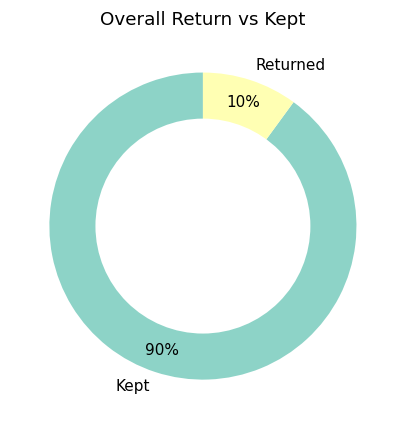

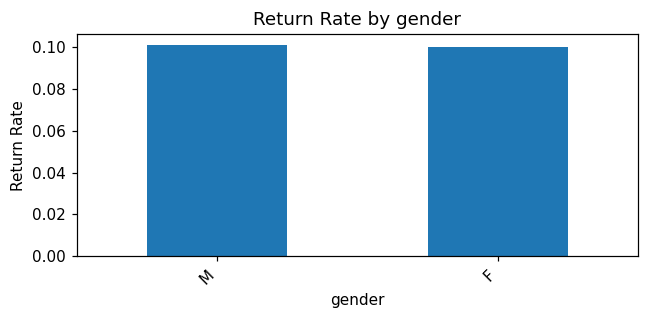

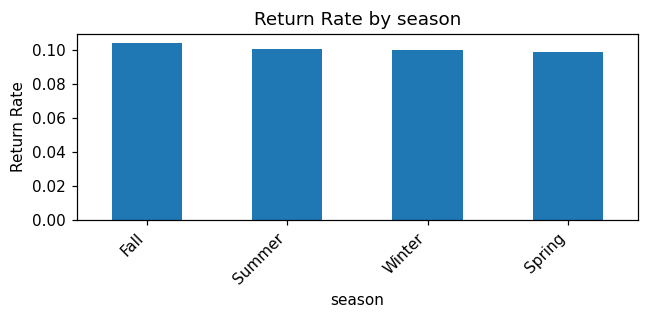

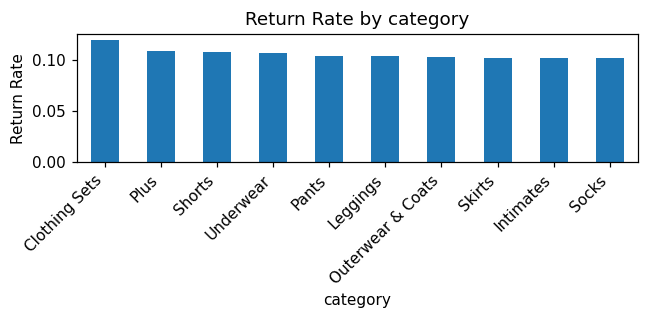

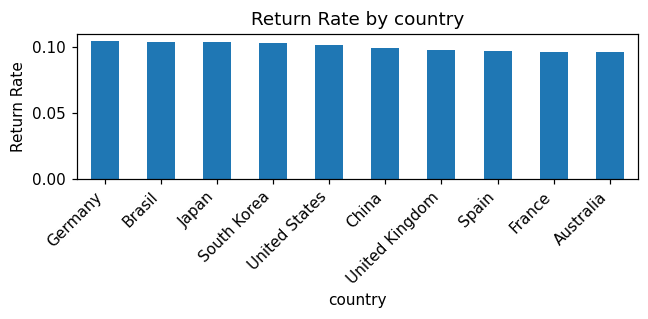

/var/folders/d3/vskdykq51ls6y387np4y9flr0000gn/T/ipykernel_14526/300377910.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


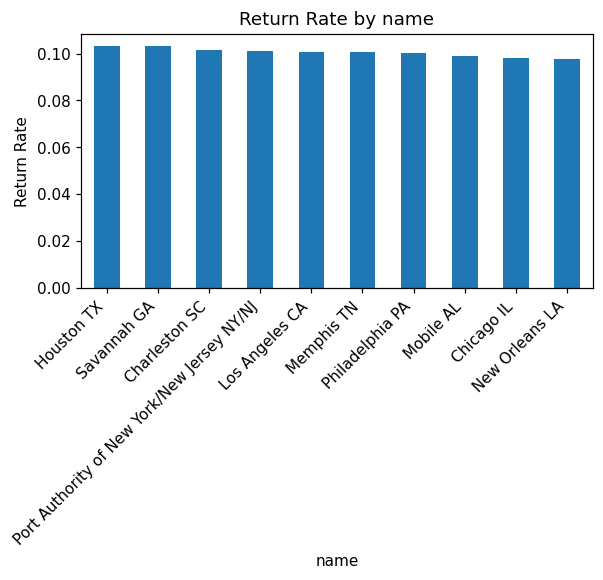

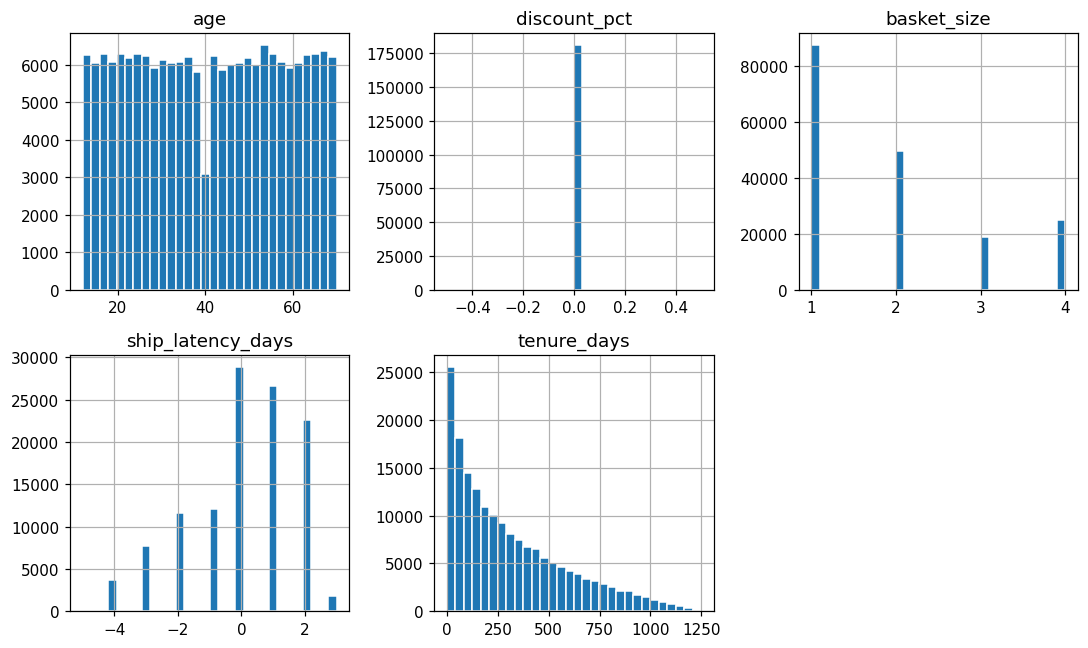

In [6]:

def donut(series, title, cmap='Set3', figsize=(4,4)):
    counts = series.value_counts()
    fig, ax = plt.subplots(figsize=figsize)
    ax.pie(counts, labels=counts.index, autopct='%1.0f%%', 
           startangle=90, pctdistance=0.85, colors=plt.get_cmap(cmap).colors)
    # Draw white circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig.gca().add_artist(centre_circle)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# Return rate helper
def return_rate(col, top_n=None, figsize=(6,3)):
    grp = df.groupby(col)['RETURN_FLAG'].mean().sort_values(ascending=False)
    if top_n:
        grp = grp.head(top_n)
    plt.figure(figsize=figsize)
    grp.plot(kind='bar')
    plt.ylabel('Return Rate')
    plt.title(f'Return Rate by {col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# ---- Donut distribution of RETURN_FLAG ----
donut(df['RETURN_FLAG'].map({1:'Returned',0:'Kept'}), 'Overall Return vs Kept')

# ---- Return rates by key categorical variables ----
return_rate('gender')
return_rate('season')
return_rate('category', top_n=10)
return_rate('country', top_n=10)
return_rate('name')  # distribution center names

# ---- Histograms for numeric variables ----
num_vars = ['age','discount_pct','basket_size','ship_latency_days','tenure_days']
df[num_vars].hist(bins=30, figsize=(10,6), layout=(2,3), edgecolor='white')
plt.tight_layout()
plt.show()


## 2️⃣ Save Feature Dataset for Modelling

In [7]:

# Selected feature columns for modelling
feature_cols = [
    # user
    'gender','age','country','tenure_days',
    # product
    'category','department','brand','retail_price','discount_pct','cost',
    # order / shipping
    'distribution_center_id','basket_size','sale_price','ship_latency_days',
    'created_hour','created_dayofweek','season',
    # target
    'RETURN_FLAG'
]

features_df = df[feature_cols].dropna(subset=['RETURN_FLAG'])  # keep rows with target

out_path = Path('returns_features_v2.csv')
features_df.to_csv(out_path, index=False)
print('Saved', features_df.shape, '→', out_path.resolve())
features_df.head()


Saved (180952, 18) → /Users/pyaelinn/Desktop/cdsp_linn/ET6-CDSP-group-17-repo-Mission_Impostible/1_datasets/returns_features_v2.csv


,gender,age,country,tenure_days,category,department,brand,retail_price,discount_pct,cost,distribution_center_id,basket_size,sale_price,ship_latency_days,created_hour,created_dayofweek,season,RETURN_FLAG
0,F,24,Brasil,72.0,Accessories,Women,Scarf_tradinginc,2.5,0.0,1.1075,3,1,2.5,1.0,0.0,Sunday,Summer,0
1,F,23,Brasil,1151.0,Accessories,Women,Scarf_tradinginc,2.5,0.0,1.1075,3,1,2.5,0.0,5.0,Tuesday,Spring,0
2,F,59,China,650.0,Accessories,Women,Scarf_tradinginc,2.5,0.0,1.1075,3,1,2.5,2.0,1.0,Sunday,Spring,0
3,F,41,United States,757.0,Accessories,Women,Scarf_tradinginc,2.5,0.0,1.1075,3,1,2.5,0.0,21.0,Tuesday,Spring,0
4,F,18,China,194.0,Accessories,Women,Scarf_tradinginc,2.5,0.0,1.1075,3,1,2.5,2.0,9.0,Wednesday,Winter,0
